In [3]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from torch.utils.tensorboard import SummaryWriter
from AutoEncoder import AutoEncoder 
import argparse
import numpy as np     
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability 
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# Create transformations to apply to each data sample 
# Can specify variations such as image flip, color flip, random crop, ...
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Load datasets for training and testing
# Inbuilt datasets available in torchvision (check documentation online)
dataset1 = datasets.MNIST('./data/', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('./data/', train=False,
                    transform=transform)

def load_data(batch_size=10, num_workers=2):
    '''
    This function loads dataloaders based on the given batchsize
    '''
    train_loader = DataLoader(dataset1, batch_size = batch_size, 
                            shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset2, batch_size = batch_size, 
                                shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader


Torch device selected:  cpu


In [5]:

def plot(num_epochs, train_losses, train_accuracies, best_accuracy, save=0, mode=1):
    ''' this function is to plot the train accuracies and train losses over iterations
    Args:
        num_epochs (int): total number of iterations (x-axis)
        train_losses (list): a list of all the losses after each iteration
        train_accuracies (list): a list of all the accuracies after each iteration
        best_accuracy (float): the best accuracy of the model
        save (int): if save == 1, the plot will be saved as a jpg image
        mode (int): the model number 
    '''
    x = range(1, num_epochs+1)

    # displaying the title
    plt.title(f'plots/model_{mode}.jpg')
    plt.plot(x, train_losses)
    plt.plot(x, train_accuracies)
    plt.legend(['Train Loss', 'Train Accuracy'], title=f'Accuracy = {best_accuracy: .2f}')
    
    if save:
        plt.savefig(f'plots/model_{mode}.jpg')
    
    plt.show()

def train(mode, model, device, train_loader, optimizer, criterion, epoch, batch_size, num_epochs):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    correct = 0
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        # print(f'{data.shape = }')

        if mode == 1: # FC layers
            data = data.reshape(-1, 28*28)
        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        
        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()
        
        # Do forward pass for current set of data
        output = model(data)

        # Compute loss based on criterion
        loss = criterion(output, data)
        # Computes gradient based on final loss
        loss.backward()
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()
        
        # Get predicted index by selecting maximum log-probability
        # pred = output.argmax(dim=1, keepdim=True)
        
        # _, predictions = output.max(1)
        # correct += (predictions == target).sum()
        print('Training epoch: ({}/{}) batch: ({}/{})'.format(epoch, num_epochs, batch_idx+1, len(train_loader)), end='\r') #. Acc: {correct}/{(batch_idx+1) * batch_size}, {100. * correct / ((batch_idx+1) * batch_size)}', end='\r')
        
    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('\nTrain set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc
    
def test(mode, model, device, test_loader, criterion, epoch, num_epochs, batch_size):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            if mode == 1:
                data = data.reshape(-1, 28*28)
            data, target = data.to(device), target.to(device)
            # Predict for data by doing forward pass
            output = model(data)
        
            # Compute loss based on same criterion as training 
            loss = criterion(output, data)
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)
            
            _, predictions = output.max(1)
            # correct += (predictions == target).sum()
            print('Testing epoch: ({}/{}) batch: ({}/{})'.format(epoch, num_epochs, batch_idx+1, len(test_loader)), end='\r')

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy


In [13]:

def run_model(mode=1, learning_rate=0.01, batch_size=10, num_epochs=60):
    '''
    this function computes training and testing with the given hyper-parameters 
    Args:
        mode (int): which model to run
        learning_rate (float): the learning rate for the optimizer
        batch_size (int): how many images does the model see for each batch
        num_epochs (int): how many times the model sees the entire dataset
    '''
    print('\nlearning_rate = {}\nbatch_size = {}\nnum_epochs = {}\n'.format(learning_rate, batch_size, num_epochs))
    # the input of the model
    image_size = 28*28
    # the output of the model
    num_classes = 10

    # Initialize the model and send to device 
    model = AutoEncoder(mode, image_size, num_classes).to(device)
    # Define loss function.
    criterion = nn.MSELoss()
    # Define optimizer function.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # Define data loaders
    train_loader, test_loader = load_data(batch_size)

    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    # Run training for n_epochs specified in config 
    for epoch in range(1, num_epochs + 1):
        # compute the accuracy and lost for each epoch
        train_loss, train_accuracy = train(mode, model, device, train_loader, optimizer, criterion, epoch, batch_size, num_epochs)
        test_loss, test_accuracy = test(mode, model, device, test_loader, criterion, epoch, num_epochs, batch_size)
        
        # store the best test accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        # save the train accuracy and train loss for this epoch so that we can plot it later
        train_losses.append(train_loss)
        # train_accuracies.append(train_accuracy.cpu().numpy())

    # after the training is completed plot the losses and accuracies against the epochs
    # plot(num_epochs, train_losses, train_accuracies, best_accuracy, save=1, mode=mode)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
    return model


# ================== Model 1 ==================
learning_rate = 0.1
batch_size = 10
num_epochs = 10

print('\n\n'+('='*32)+' Training model 1 '+('='*32))
model1 = run_model(mode=1, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)    
print('='*80)

# ================== Model 2 ==================
learning_rate = 0.1
batch_size = 10
num_epochs = 10

print(('='*32)+' Training model 2 '+('='*32))

model2 = run_model(mode=2, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
print('='*80)




================================ Training model 1 ================================

learning_rate = 0.1
batch_size = 10
num_epochs = 10

Training epoch: (1/10) batch: (6000/6000)
Train set (1/10): Average loss: 0.7451, Accuracy: 0/60000 (0%)

Testing epoch: (1/10) batch: (1000/1000)
Test set (1/10): Average loss: 0.6500, Accuracy: 0/10000 (0%)

Training epoch: (2/10) batch: (6000/6000)
Train set (2/10): Average loss: 0.6279, Accuracy: 0/60000 (0%)

Testing epoch: (2/10) batch: (1000/1000)
Test set (2/10): Average loss: 0.6153, Accuracy: 0/10000 (0%)

Training epoch: (3/10) batch: (6000/6000)
Train set (3/10): Average loss: 0.6032, Accuracy: 0/60000 (0%)

Testing epoch: (3/10) batch: (1000/1000)
Test set (3/10): Average loss: 0.5959, Accuracy: 0/10000 (0%)

Training epoch: (4/10) batch: (6000/6000)
Train set (4/10): Average loss: 0.5842, Accuracy: 0/60000 (0%)

Testing epoch: (4/10) batch: (1000/1000)
Test set (4/10): Average loss: 0.5785, Accuracy: 0/10000 (0%)

Training epoch: (5/10

In [14]:
import os
from PIL import Image
import numpy as np

def show(org, recon_img):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(org, cmap='gray')
    axarr[1].imshow(recon_img, cmap='gray')
    # plt.imshow(img, cmap='gray')
    

def show_recon_images(mode, model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    data = {}
    # Set model to eval mode to notify all layers.
    model.eval()
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            img, target = sample

            target = target.numpy()[0]
            if target not in data.keys():
                data[target] = [img]
            else:
                data[target].append(img)

    for target, images in data.items():
        for i, image in enumerate(images[:2]):
            if mode == 1:
                image = image.reshape(-1, 28*28)
            image = image.to(device)
            # Predict for data by doing forward pass
            output = model(image)
            output = output.reshape(-1, 28, 28).detach().numpy()[0]
            image = image.reshape(-1, 28, 28)[0]
            # show(image, output)
            # f, axarr = plt.subplots(1,2)
            # axarr[0].imshow(image, cmap='gray')
            # axarr[1].imshow(output, cmap='gray')

            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Original")

            plt.subplot(1, 2, 2)
            plt.imshow(output, cmap='gray')
            plt.title("Re-constructed")

            plt.suptitle(target)

            save_path = f'outputs/model{mode}/{target}/'
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            
            plt.savefig(save_path+f'{target}_{i}.jpg')
        # break
            
        

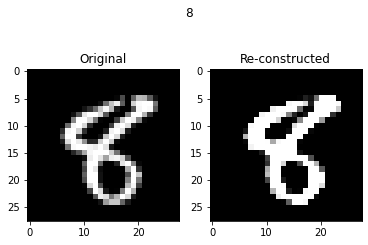

In [15]:
# Define loss function.
criterion = nn.MSELoss()
# Define optimizer function.
# Define data loaders
train_loader, test_loader = load_data(batch_size=1)

mode = 1
show_recon_images(mode, model1, device, test_loader)

mode = 2
show_recon_images(mode, model2, device, test_loader)